Index เป็น unique หรือไม่: True


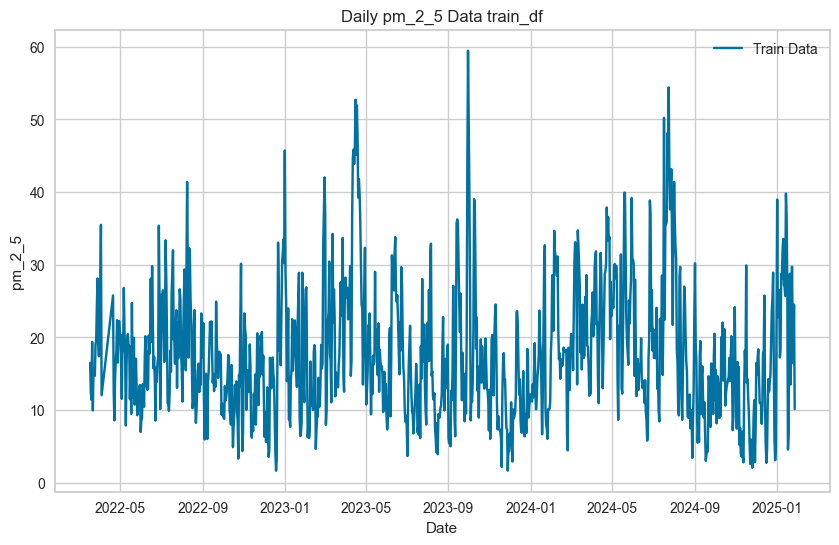

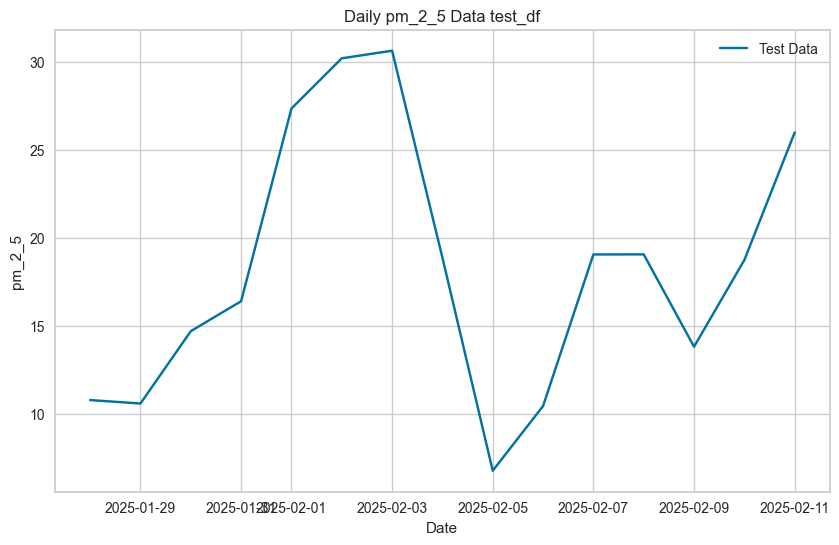

🔍 ตรวจสอบคอลัมน์ที่มีอยู่จริงใน train_df: Index(['pm_2_5', 'temperature', 'humidity', 'pm_2_5_sp', 'day', 'month',
       'year', 'season_rainy', 'season_summer', 'season_winter', 'monsoon_sw',
       'monsoon_ne', 'transition_period', 'indonesia_fire', 'calm_wind_period',
       'school_term', 'university_term', 'wind_level',
       'agriculture_production', 'automotive_production',
       'consumer_goods_production', 'freight_transport', 'energy_production',
       'is_holiday'],
      dtype='object')
🔍 ตรวจสอบคอลัมน์ที่มีอยู่จริงใน test_df: Index(['pm_2_5', 'temperature', 'humidity', 'pm_2_5_sp', 'day', 'month',
       'year', 'season_rainy', 'season_summer', 'season_winter', 'monsoon_sw',
       'monsoon_ne', 'transition_period', 'indonesia_fire', 'calm_wind_period',
       'school_term', 'university_term', 'wind_level',
       'agriculture_production', 'automotive_production',
       'consumer_goods_production', 'freight_transport', 'energy_production',
       'is_holiday'],
     

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1047, 14)"
5,Transformed data shape,"(1047, 14)"
6,Transformed train set shape,"(1032, 14)"
7,Transformed test set shape,"(15, 14)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:17:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,ARIMA


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pycaret.time_series import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.utils.time_series import clean_time_index
import holidays
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv("daily_csv/export-jsps014-1d.csv", parse_dates=["timestamp"], index_col="timestamp")
df = df.drop(columns=["Unnamed: 0"], errors='ignore')
print("Index เป็น unique หรือไม่:", df.index.is_unique)

df = df[:]
# ลบ index ที่ซ้ำกันและตั้งค่าความถี่เป็นรายวัน
df = df[~df.index.duplicated(keep="last")]
df = df.interpolate(method='spline', order=2)
df = df.asfreq("D")

# กำหนดเกณฑ์สำหรับค่า pm_2_5
df = df[(df['pm_2_5'] >= 0) & (df['pm_2_5'] <= 100)]
df = df[(df['pm_2_5_sp'] >= 0) & (df['pm_2_5'] <= 130)]

# ใช้เฉพาะคอลัมน์ที่ต้องการ
df = df[['pm_2_5','temperature','humidity','pm_2_5_sp']]  # ใช้แค่ pm_2_5 สำหรับการทำนาย
df = clean_time_index(data=df, freq="D")

# เพิ่มฟีเจอร์ วัน, เดือน, ปี
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

# เพิ่มฟีเจอร์ "ฤดูกาล" ของประเทศไทย
def get_thai_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9, 10]:
        return 'rainy'
    else:
        return 'winter'

df['season'] = df['month'].apply(get_thai_season)

# One-hot encoding สำหรับฤดูกาล
df = pd.get_dummies(df, columns=['season'], prefix='season')

# เพิ่มฟีเจอร์เกี่ยวกับลมมรสุม
def get_monsoon_features(month):
    if month in [6, 7, 8, 9, 10]:  # ฤดูฝน (ลมมรสุมตะวันตกเฉียงใต้)
        return 1, 0, 0
    elif month in [11, 12, 1, 2]:  # ฤดูหนาว (ลมมรสุมตะวันออกเฉียงเหนือ)
        return 0, 1, 0
    else:  # ช่วงเปลี่ยนผ่าน (เมษายน-พฤษภาคม)
        return 0, 0, 1

df[['monsoon_sw', 'monsoon_ne', 'transition_period']] = df['month'].apply(
    lambda x: pd.Series(get_monsoon_features(x))
)

# เพิ่มฟีเจอร์ "อิทธิพลจากไฟป่าอินโดนีเซีย"
def get_indonesia_fire(month):
    if month in [8, 9, 10]:  # อิทธิพลจากไฟป่าอินโดนีเซีย
        return 1
    else:
        return 0

df['indonesia_fire'] = df['month'].apply(get_indonesia_fire)

# เพิ่มฟีเจอร์ "ช่วงที่ลมหยุดนิ่ง" (Calm Wind Period)
def get_calm_wind_period(month):
    if month in [4, 5, 10, 11]:  # ช่วงเปลี่ยนผ่านมรสุม
        return 1
    else:
        return 0

df['calm_wind_period'] = df['month'].apply(get_calm_wind_period)

# เพิ่มฟีเจอร์ "ช่วงปิดเทอมและเปิดเทอม"
def get_school_term(month):
    if month in [5, 6, 7, 8, 9]:  # เปิดเทอม 1 (กลางพฤษภาคม - ต้นตุลาคม)
        return 1
    elif month in [11, 12, 1, 2]:  # เปิดเทอม 2 (ต้นพฤศจิกายน - ปลายกุมภาพันธ์)
        return 1
    else:  # ปิดเทอม
        return 0

def get_university_term(month):
    if month in [8, 9, 10, 11, 12]:  # เปิดเทอม 1 (สิงหาคม - ธันวาคม)
        return 1
    elif month in [1, 2, 3, 4, 5]:  # เปิดเทอม 2 (มกราคม - พฤษภาคม)
        return 1
    else:  # ปิดเทอม
        return 0

df['school_term'] = df['month'].apply(get_school_term)
df['university_term'] = df['month'].apply(get_university_term)

# เพิ่มฟีเจอร์ "ความแรงลม" (Wind Level)
def get_wind_level(month):
    if month in [6, 7, 8, 9]:  # ลมแรงมาก (Level 4)
        return 4
    elif month in [5, 10]:  # ลมแรง (Level 3)
        return 3
    elif month in [1, 2, 12]:  # ลมปานกลาง (Level 2)
        return 2
    elif month in [3, 4, 11]:  # ลมอ่อน (Level 1)
        return 1
    else:  # ลมสงบ (Level 0)
        return 0

df['wind_level'] = df['month'].apply(get_wind_level)

# เพิ่มฟีเจอร์ "ระดับการผลิต" ของโรงงาน 3 ประเภท
def get_agriculture_production(month):
    if month in [1, 2, 3]:  # มกราคม - มีนาคม (เก็บเกี่ยวผลผลิต)
        return 4
    elif month in [9, 10, 11, 12]:  # กันยายน - ธันวาคม (ปลูกพืช)
        return 3
    else:  # เมษายน - สิงหาคม (ฤดูฝน, การผลิตลดลง)
        return 1

def get_automotive_production(month):
    if month in [1, 2, 3]:  # มกราคม - มีนาคม (เริ่มปีใหม่, การผลิตเพิ่มขึ้น)
        return 4
    elif month in [10, 11, 12]:  # ตุลาคม - ธันวาคม (สิ้นปี, การผลิตเพิ่มขึ้น)
        return 3
    else:  # เมษายน - กันยายน (ฤดูฝน, การผลิตลดลง)
        return 2

def get_consumer_goods_production(month):
    if month in [1, 2, 3]:  # มกราคม - มีนาคม (เทศกาลปีใหม่, การผลิตเพิ่มขึ้น)
        return 4
    elif month in [10, 11, 12]:  # ตุลาคม - ธันวาคม (เทศกาลสิ้นปี, การผลิตเพิ่มขึ้น)
        return 3
    else:  # เมษายน - กันยายน (ฤดูฝน, การผลิตลดลง)
        return 2

df['agriculture_production'] = df['month'].apply(get_agriculture_production)
df['automotive_production'] = df['month'].apply(get_automotive_production)
df['consumer_goods_production'] = df['month'].apply(get_consumer_goods_production)

# เพิ่มฟีเจอร์ "การขนส่งสินค้า" (Freight Transport)
def get_freight_transport(month):
    if month in [1, 4, 5, 6, 7, 8]:  # เดือนที่มีการขนส่งสูง
        return 4
    elif month in [2, 3, 9, 10]:  # เดือนที่มีการขนส่งปานกลาง
        return 3
    else:  # เดือนที่มีการขนส่งต่ำ
        return 2

df['freight_transport'] = df['month'].apply(get_freight_transport)

# เพิ่มฟีเจอร์ "การผลิตพลังงาน" (Energy Production)
def get_energy_production(month):
    if month in [1, 2, 3, 12]:  # เดือนที่มีการใช้พลังงานสูง
        return 4
    elif month in [4, 5, 6, 7]:  # เดือนที่มีการใช้พลังงานปานกลาง
        return 3
    else:  # เดือนที่มีการใช้พลังงานต่ำ
        return 2

df['energy_production'] = df['month'].apply(get_energy_production)

# แปลง PeriodIndex เป็น DatetimeIndex เพื่อใช้กับ holidays
df.index = df.index.to_timestamp()

# เพิ่มฟีเจอร์ "วันหยุด" ของประเทศไทย
thai_holidays = holidays.TH(years=df.index.year.unique())
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in thai_holidays else 0)

# แปลง DatetimeIndex กลับเป็น PeriodIndex
df.index = df.index.to_period('D')

# แปลงประเภทข้อมูลของคอลัมน์ให้เป็นตัวเลข
df['is_holiday'] = df['is_holiday'].astype(int)
df['season_summer'] = df['season_summer'].astype(int)
df['season_rainy'] = df['season_rainy'].astype(int)
df['season_winter'] = df['season_winter'].astype(int)
df['monsoon_sw'] = df['monsoon_sw'].astype(int)
df['monsoon_ne'] = df['monsoon_ne'].astype(int)
df['transition_period'] = df['transition_period'].astype(int)
df['indonesia_fire'] = df['indonesia_fire'].astype(int)
df['calm_wind_period'] = df['calm_wind_period'].astype(int)
df['school_term'] = df['school_term'].astype(int)
df['university_term'] = df['university_term'].astype(int)
df['wind_level'] = df['wind_level'].astype(int)
df['agriculture_production'] = df['agriculture_production'].astype(int)
df['automotive_production'] = df['automotive_production'].astype(int)
df['consumer_goods_production'] = df['consumer_goods_production'].astype(int)
df['freight_transport'] = df['freight_transport'].astype(int)
df['energy_production'] = df['energy_production'].astype(int)

# แบ่งข้อมูลเป็น train set และ test set
train_size = len(df) - 15
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# เติมค่าหายไปใน train set
train_df = train_df.interpolate(method='linear', limit_direction='forward')
train_df = train_df.clip(lower=0)  # กำหนดให้ค่าต่ำสุดเป็น 0

# พล็อตข้อมูลอนุกรมเวลา
plt.figure(figsize=(10, 6))
plt.plot(train_df.index.to_timestamp(), train_df['pm_2_5'], label='Train Data')
plt.title('Daily pm_2_5 Data train_df')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_df.index.to_timestamp(), test_df['pm_2_5'], label='Test Data')
plt.title('Daily pm_2_5 Data test_df')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.legend()
plt.show()

# ตรวจสอบประเภทข้อมูลของ train_df
# print(train_df.dtypes)



# ฟีเจอร์ที่ใช้ในโมเดล
features = [
    'pm_2_5_sp',
    'energy_production','agriculture_production','automotive_production','consumer_goods_production',
    'is_holiday','wind_level','school_term','university_term','monsoon_sw','monsoon_ne',     
    'temperature','humidity',  # เพิ่มฟีเจอร์ใหม่
]

print("🔍 ตรวจสอบคอลัมน์ที่มีอยู่จริงใน train_df:", train_df.columns)
print("🔍 ตรวจสอบคอลัมน์ที่มีอยู่จริงใน test_df:", test_df.columns)
# ดึงค่าวันสุดท้ายใน train_df สำหรับแต่ละฟีเจอร์
last_train_values = train_df[['pm_2_5_sp', 'temperature', 'humidity']].iloc[-1]




lookback_days = 700

for feature in ['pm_2_5_sp', 'temperature', 'humidity']:
    # ดึงข้อมูลย้อนหลัง
    last_days = train_df[feature].iloc[-lookback_days:]

    # สร้าง Polynomial Regression model (degree = 3 สำหรับเคิร์ฟที่ชัดเจน)
    model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
    
    # สร้างข้อมูล X และ y
    X = np.arange(len(last_days)).reshape(-1, 1)  # เวลา (index)
    y = last_days.values  # ค่าของ feature

    # ฝึกโมเดล
    model.fit(X, y)

    # ทำนายค่าใน test_df
    X_test = np.arange(len(test_df)).reshape(-1, 1)
    trend_forecast = model.predict(X_test)

    # ใช้ค่าแนวโน้มที่คำนวณได้เป็นค่าของ test_df โดยไม่เพิ่ม noise
    test_df[feature] = trend_forecast

    # คำนวณ differencing จากค่าสุดท้ายของ train
    test_df[f'{feature}_diff'] = test_df[feature] - train_df[feature].iloc[-1]

    # ตรวจสอบค่าไม่ติดลบ (เช่น สำหรับ pm_2_5_sp)
    if feature == 'pm_2_5_sp':
        test_df[feature] = np.maximum(test_df[feature], 0)
        test_df[f'{feature}_diff'] = test_df[feature] - train_df[feature].iloc[-1]

# เติมข้อมูลใน test_df ด้วย Linear Interpolation
test_df = test_df.interpolate(method='linear', limit_direction='forward')

# ตั้งค่า PyCaret
exp = TSForecastingExperiment()
exp.setup(
    data=train_df[['pm_2_5',
    'pm_2_5_sp',  # ใช้ pm_2_5_sp ที่ผ่าน Differencing
    'energy_production','agriculture_production','automotive_production','consumer_goods_production',
    'is_holiday','wind_level', 'school_term','university_term','monsoon_sw','monsoon_ne',
    'temperature','humidity',  # ใช้ temperature และ humidity ที่ผ่าน Differencing
]],  # ใช้ train_df ทั้งหมด
    target='pm_2_5', 
    session_id=123, 
    fh=15, 
    use_gpu=True
)

# สร้างโมเดล ARIMA ด้วย Hyperparameters ที่ปรับแล้ว
model = exp.create_model('arima', order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

model = exp.finalize_model(model)

# ทำนายค่า pm_2_5
forecast = exp.predict_model(model, fh=15, X=test_df[[
    'pm_2_5_sp_diff',  # ใช้ pm_2_5_sp ที่ผ่าน Differencing
    'energy_production','agriculture_production','automotive_production','consumer_goods_production',
    'is_holiday','wind_level', 'school_term','university_term','monsoon_sw','monsoon_ne',
    'temperature_diff','humidity_diff',  # ใช้ temperature และ humidity ที่ผ่าน Differencing
]])  # ใช้ฟีเจอร์ที่ผ่าน Differencing และฟีเจอร์อื่น ๆ

# ปรับค่าทำนายให้ไม่เป็นลบ
forecast['y_pred'] = np.maximum(forecast['y_pred'], 0)

# แสดงผลลัพธ์
print("Forecast:")
print(forecast)

# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(df.index[-50:].to_timestamp(), df['pm_2_5'][-50:], label='Actual', marker='o')
plt.plot(forecast.index.to_timestamp(), forecast['y_pred'], label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.title('Actual vs Forecasted pm_2_5')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

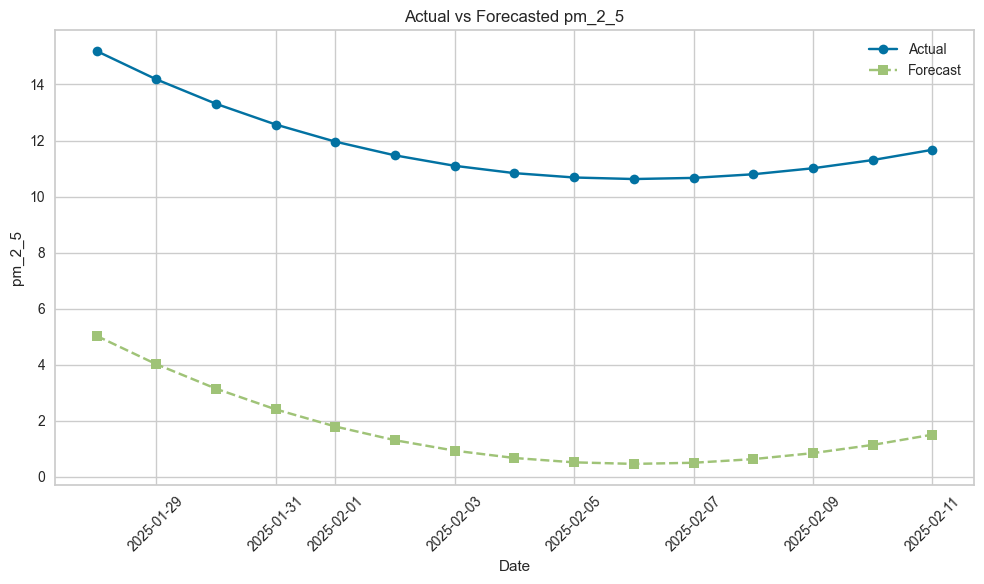

In [ ]:
# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(test_df.index.to_timestamp(), test_df['pm_2_5_sp'], label='Actual', marker='o')
plt.plot(test_df.index, test_df['pm_2_5_sp_diff'], label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.title('Actual vs Forecasted pm_2_5')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
import numpy as np

# ดึงค่าจริงจาก test_df
actual = test_df['pm_2_5']

# ดึงค่าทำนายจาก forecast
predicted = forecast['y_pred']

# คำนวณ MAE
mae = mean_absolute_error(actual, predicted)

# คำนวณ MSE
mse = mean_squared_error(actual, predicted)

# คำนวณ RMSE
rmse = np.sqrt(mse)

# คำนวณ MAPE โดยใช้ฟังก์ชันจาก sklearn
mape = mean_absolute_percentage_error(actual, predicted) * 100  # แปลงเป็นเปอร์เซ็นต์

# คำนวณ R²
r2 = r2_score(actual, predicted)

# คำนวณความแม่นยำ (Accuracy)
mean_actual = np.mean(actual)
accuracy = 100 - mape 

# แสดงผลลัพธ์
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"ความแม่นยำ (Accuracy): {accuracy:.2f}%")

MAE: 9.6328
MSE: 145.6716
RMSE: 12.0694
MAPE: 44.59%
R²: -1.7978
ความแม่นยำ (Accuracy): 55.41%
